In [2]:
from pandas import DataFrame
from pandas import read_csv
from pandas import datetime
from matplotlib import pyplot
import pandas as pd

def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')

series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
print(series.head())
series.plot()
pyplot.show()

<ipython-input-2-181cbb4ebb8d>:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


ValueError: time data '190Sales of shampoo over a three year period' does not match format '%Y-%m'

positive correlation with the first 10-to-12 lags that is perhaps significant for the first 5 lags.

A good starting point for the AR parameter of the model may be 5.

## Modelling

In [3]:
from statsmodels.tsa.arima.model import ARIMA

series.index = series.index.to_period('M')


In [4]:
series

Month
1901-01    266.0
1901-02    145.9
1901-03    183.1
1901-04    119.3
1901-05    180.3
1901-06    168.5
1901-07    231.8
1901-08    224.5
1901-09    192.8
1901-10    122.9
1901-11    336.5
1901-12    185.9
1902-01    194.3
1902-02    149.5
1902-03    210.1
1902-04    273.3
1902-05    191.4
1902-06    287.0
1902-07    226.0
1902-08    303.6
1902-09    289.9
1902-10    421.6
1902-11    264.5
1902-12    342.3
1903-01    339.7
1903-02    440.4
1903-03    315.9
1903-04    439.3
1903-05    401.3
1903-06    437.4
1903-07    575.5
1903-08    407.6
1903-09    682.0
1903-10    475.3
1903-11    581.3
1903-12    646.9
Freq: M, Name: Sales, dtype: float64

In [5]:
# fit model
model = ARIMA(series, order=(5,1,0))
model_fit = model.fit()

In [6]:
# summary of fit model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  Sales   No. Observations:                   36
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -198.485
Date:                Sat, 19 Dec 2020   AIC                            408.969
Time:                        11:45:36   BIC                            418.301
Sample:                    01-31-1901   HQIC                           412.191
                         - 12-31-1903                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9014      0.247     -3.647      0.000      -1.386      -0.417
ar.L2         -0.2284      0.268     -0.851      0.395      -0.754       0.298
ar.L3          0.0747      0.291      0.256      0.7

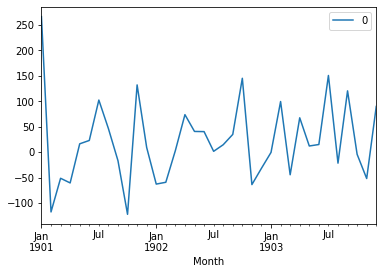

In [7]:
# line plot of residuals
residuals = DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()


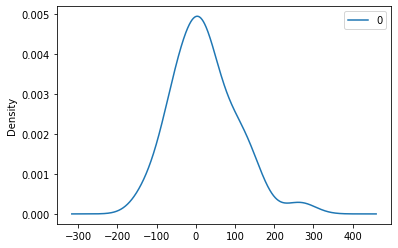

In [8]:
# density plot of residuals
residuals.plot(kind='kde')
pyplot.show()


In [9]:
# summary stats of residuals
print(residuals.describe())

                0
count   36.000000
mean    21.936145
std     80.774430
min   -122.292030
25%    -35.040859
50%     13.147219
75%     68.848286
max    266.000000


## Rolling Forecast

In [10]:

from sklearn.metrics import mean_squared_error
from math import sqrt
# load dataset
def parser(x):
    return datetime.strptime('190'+x, '%Y-%m')
series = read_csv('shampoo.csv', header=0, index_col=0, parse_dates=True, squeeze=True, date_parser=parser)
series.index = series.index.to_period('M')


In [11]:
# split into train and test sets
X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()


In [12]:
size

23

In [13]:
len(X)

36

In [14]:
# walk-forward validation
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))


predicted=343.272180, expected=342.300000
predicted=293.329674, expected=339.700000
predicted=368.668956, expected=440.400000
predicted=335.044741, expected=315.900000
predicted=363.220221, expected=439.300000
predicted=357.645324, expected=401.300000
predicted=443.047835, expected=437.400000
predicted=378.365674, expected=575.500000
predicted=459.415020, expected=407.600000
predicted=526.890876, expected=682.000000
predicted=457.231275, expected=475.300000
predicted=672.914944, expected=581.300000
predicted=531.541449, expected=646.900000


Test RMSE: 89.021


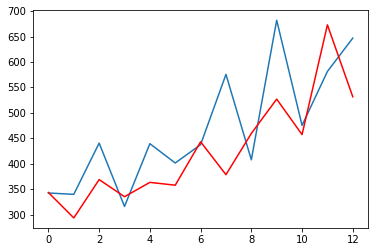

In [15]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
pyplot.plot(test)
pyplot.plot(predictions, color='red')
pyplot.show()